# Neural Processes

This implementation is based on [EmilienDupont/neural-processes]((https://github.com/EmilienDupont/neural-processes)).

## Overview of files

- **neuralprocess.py** contains *NeuralProcess()* model class and the following functions:
  - *__init__()* - Initialisies all three coders
    - *self.xy_to_r* - rEncoder
    - *self.r_to_mu_sigma* - zEncoder
    - *self.xz_to_y* - Decoder
  - *aggregate()* - Mean aggregation, permutation invariance
  - *xy_to_mu_sigm()* - Encoding via rEncoder and zEncoder
  - *forward()* - full forward pass
    - *training mode* - uses target encoding for z?!
    - *testing mode*  
  

- **coders.py** contains all three coders
  - *rEncoder()* - 2-layer (2 hidden layers) MLP with ReLu activation functions. Last layer without activation.
  - *zEncoder()* - linear mapping to z parameters. Sigma is defined using 0.1 + 0.9 * sigmoid(). 
  - *Decoder()* - 3-layer (3 hidden layers) MLP with ReLu activation functions. Sigma is defined using 0.1 + 0.9 * softplus(). 

- **utisl.py** contains helper functions:
  - *context_target_split()* - samples x_target, y_target and their subsets x_context and x_target.

- **datasets.py**
  - *SineData()*
  - *SineDisconData()*

-  **training.py** contains *NeuralProcessTrainer()* class and the following functions:


## Implementation recommendations: 

- [Le, Tuan Anh, et al. "Empirical evaluation of neural process objectives." NeurIPS workshop on Bayesian Deep Learning. Vol. 4. 2018.](http://bayesiandeeplearning.org/2018/papers/92.pdf)
  - context size m
  - target size n (superset) with m < n.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visualize Data

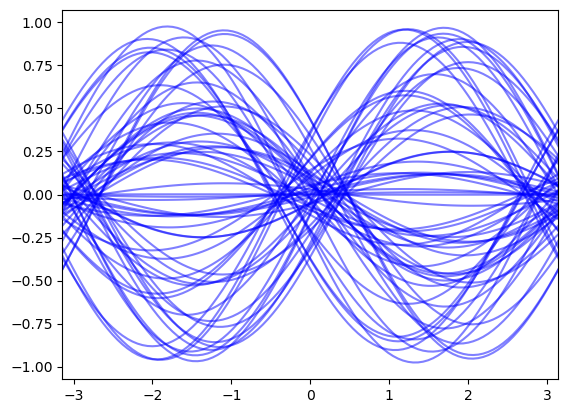

In [11]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range = (-1, 1), # amplitude_range = (1, 1)
                   shift_range = (-0.5, 0.5), # shift_range = (-.5, .5) shift_range = (0, 0)
                   num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

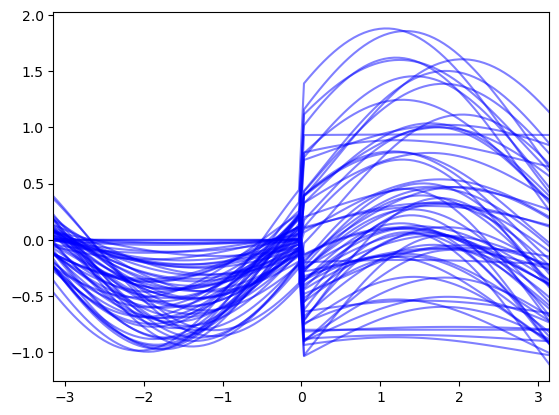

In [4]:
from math import pi
from datasets import SineDiscontData

dataset = SineDiscontData(num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [5]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

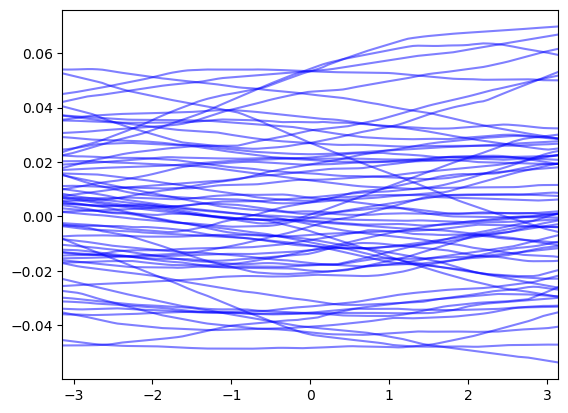

In [6]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [8]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 7.245
iteration 400, loss 7.858
iteration 600, loss 4.486
iteration 800, loss 2.355
iteration 1000, loss 1.219
Epoch: 0, Avg_loss: 4.105670004653744
iteration 1200, loss -0.285
iteration 1400, loss 0.939
iteration 1600, loss 1.168
iteration 1800, loss 4.535
iteration 2000, loss -0.988
Epoch: 1, Avg_loss: 1.9642327457331121
iteration 2200, loss 1.222
iteration 2400, loss -1.246
iteration 2600, loss -0.988
iteration 2800, loss 1.604
iteration 3000, loss -0.196
Epoch: 2, Avg_loss: 0.9670048482865096
iteration 3200, loss 0.684
iteration 3400, loss -1.838
iteration 3600, loss 1.144
iteration 3800, loss 1.336
iteration 4000, loss -0.612
Epoch: 3, Avg_loss: 0.6036262381859123
iteration 4200, loss 3.344
iteration 4400, loss -0.166
iteration 4600, loss 3.097
iteration 4800, loss -0.157
iteration 5000, loss -1.048
Epoch: 4, Avg_loss: 0.39632274582982063
iteration 5200, loss 2.934
iteration 5400, loss -0.659
iteration 5600, loss -1.591
iteration 5800, loss 3.036
iteration 6000

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

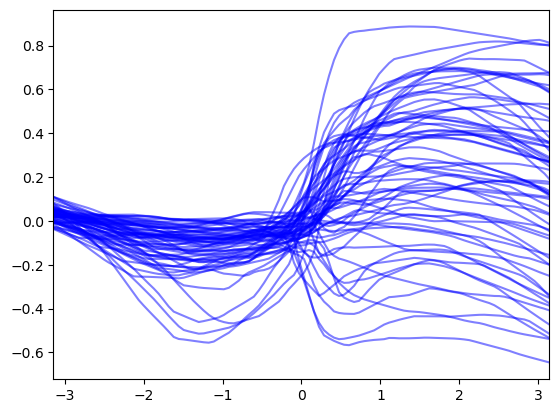

In [9]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

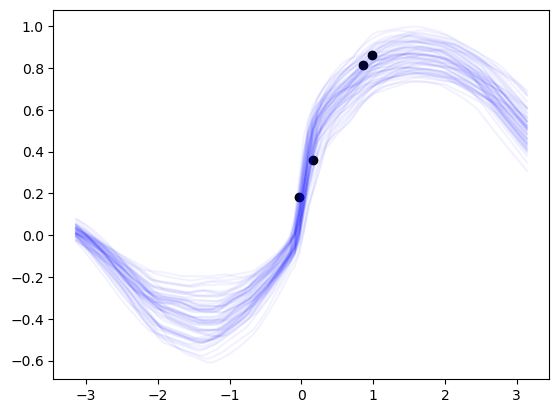

In [27]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')